In [3]:
!gdown 1loK4di5-v7lNKtVpTSmPbg_CsDXbkuVY
!gdown 1PB24Cp5kJaqaF7Gf8KTCHU9WDa9XqSWR
!gdown 1eNtYuG6jFM5oLjrb_QHwej-DTENV3zuC

Downloading...
From: https://drive.google.com/uc?id=1loK4di5-v7lNKtVpTSmPbg_CsDXbkuVY
To: /content/transaction_types.csv
100% 980/980 [00:00<00:00, 3.34MB/s]
Downloading...
From: https://drive.google.com/uc?id=1PB24Cp5kJaqaF7Gf8KTCHU9WDa9XqSWR
To: /content/mcc_group_definition.csv
100% 343/343 [00:00<00:00, 1.18MB/s]
Downloading...
From: https://drive.google.com/uc?id=1eNtYuG6jFM5oLjrb_QHwej-DTENV3zuC
To: /content/2016-09-19_79351_training.csv
100% 32.0M/32.0M [00:00<00:00, 82.2MB/s]


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import calendar
import seaborn as sns
import numpy as np

# **Data Loading**

In [5]:
df_training = pd.read_csv('/content/2016-09-19_79351_training.csv')
df_definition = pd.read_csv('/content/mcc_group_definition.csv') # lookup table
df_transaction = pd.read_csv('/content/transaction_types.csv') # lookup table

Merging Tables to make a base table (one point of truth)

In [6]:
# merging informaation from lookup tables
df_merged = pd.merge(df_training,df_definition,on='mcc_group',how='left')
df_merged.rename(columns={'explanation':'mcc_group_explanation'},inplace = True)
base_df = pd.merge(df_merged,df_transaction,left_on='transaction_type',right_on='type',how='left')
base_df.drop('type', axis=1, inplace=True)
base_df.rename(columns={'explanation':'transaction_type_explanation','direction':'transaction_direction','agent':'transaction_agent'},inplace = True)
base_df.head()

,user_id,transaction_date,transaction_type,mcc_group,amount_n26_currency,dataset_transaction,dataset_user,mcc_group_explanation,transaction_type_explanation,transaction_direction,transaction_agent
0,a78884f5e76951188c1e719d4956773a,2016-02-01,DT,NaN,350,training,training,NaN,Debit Transfer,Out,Bank Account
1,b0333294fef6ff1299102a70ad46b126,2016-02-01,DT,NaN,202,training,training,NaN,Debit Transfer,Out,Bank Account
2,7b8d2a2780adae0cd0c248e92c1b28dc,2016-02-01,DT,NaN,291,training,training,NaN,Debit Transfer,Out,Bank Account
3,cc4abaa500f7db4390ae3f02bd36d805,2016-02-01,DT,NaN,214,training,training,NaN,Debit Transfer,Out,Bank Account
4,49b99d1d5ba028566639e8b3eb7c055b,2016-02-01,DT,NaN,272,training,training,NaN,Debit Transfer,Out,Bank Account


Some of the columns in base_df contribute nothing to the dataset. Either these are just explaination of other columns e.g (transaction_type:transaction_type_explanation) or some represent no information about data. So we will drop these already.

In [7]:
base_df.drop(columns=['transaction_type','mcc_group','dataset_transaction','dataset_user'],inplace=True)

In [8]:
# fix datetime
base_df['transaction_date'] = pd.to_datetime(base_df['transaction_date'])

# **EDA**

In [54]:
base_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 408546 entries, 0 to 408545
Data columns (total 7 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   user_id                       408546 non-null  object        
 1   transaction_date              408546 non-null  datetime64[ns]
 2   amount_n26_currency           408546 non-null  int64         
 3   mcc_group_explanation         408546 non-null  object        
 4   transaction_type_explanation  408546 non-null  object        
 5   transaction_direction         408546 non-null  object        
 6   transaction_agent             408546 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(5)
memory usage: 24.9+ MB


In [55]:
print('user_ids unique {} '.format(base_df.user_id.nunique()))
print('transactions_date {} to {}'.format(base_df.transaction_date.min(),base_df.transaction_date.max()))
print('transaction_type samples: {}'.format(base_df.transaction_type_explanation.unique()[:4]))
print('transaction_amount ranges from {} to {}'.format(base_df.amount_n26_currency.min(),base_df.amount_n26_currency.max()))
print('mcc_group samples : {}'.format(base_df.mcc_group_explanation.unique()[:4]))
print('transaction_agent samples: {}'.format(base_df.transaction_agent.unique()))
print('transcation_directions unique values {}'.format(base_df.transaction_direction.unique()))

user_ids unique 10000 
transactions_date 2016-02-01 00:00:00 to 2016-07-31 00:00:00
transaction_type samples: ['Debit Transfer' 'Credit Transfer' 'Debit Reversal' 'MoneyBeam Transfer']
transaction_amount ranges from 3 to 1166
mcc_group samples : ['unknown_debited' 'unknown_credited' 'Shopping/(Fashion)' 'Transport']
transaction_agent samples: ['Bank Account' 'Card' 'Partner']
transcation_directions unique values ['Out' 'In']


Analyze null values

In [80]:
base_df.transaction_type_explanation.value_counts(normalize=True)

Presentment        0.632301
Credit Transfer    0.156254
Debit Transfer     0.099201
Direct Debit       0.073110
OTHER              0.039134
Name: transaction_type_explanation, dtype: float64

In [79]:
base_df.mcc_group_explanation.value_counts(dropna=False,normalize=True)

unknown_debited       0.191158
unknown_credited      0.176541
ATM                   0.170867
OTHER                 0.126253
Groceries             0.123820
Travel/Hotel          0.060390
Gastronomie           0.051096
Automotive/Gas        0.050447
Shopping/(Fashion)    0.049429
Name: mcc_group_explanation, dtype: float64

In [58]:
print(base_df[base_df.mcc_group_explanation.isna()].transaction_direction.value_counts())
print("The null values from mcc_group are income and credited both, so we have to fill them accordingly")
# print(base_df[base_df.mcc_group_explanation.isna()].transaction_agent.value_counts())
# print(base_df[base_df.mcc_group_explanation.isna()].transaction_type_explanation.value_counts())

Series([], Name: transaction_direction, dtype: int64)
The null values from mcc_group are income and credited both, so we have to fill them accordingly


EDA for Expenditure and Income

In [59]:
base_df.describe(include='all')

<ipython-input-59-50a969d3a9c4>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  base_df.describe(include='all')


,user_id,transaction_date,amount_n26_currency,mcc_group_explanation,transaction_type_explanation,transaction_direction,transaction_agent
count,408546,408546,408546.000000,408546,408546,408546,408546
unique,10000,182,NaN,14,7,2,3
top,d4ba03459f726f32bf24fe3801c24958,2016-07-06 00:00:00,NaN,unknown_debited,Presentment,Out,Card
freq,483,5393,NaN,78097,258324,336421,258324
first,NaN,2016-02-01 00:00:00,NaN,NaN,NaN,NaN,NaN
last,NaN,2016-07-31 00:00:00,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,52.764164,NaN,NaN,NaN,NaN
std,NaN,NaN,111.870681,NaN,NaN,NaN,NaN
min,NaN,NaN,3.000000,NaN,NaN,NaN,NaN
25%,NaN,NaN,7.000000,NaN,NaN,NaN,NaN


<Axes: >

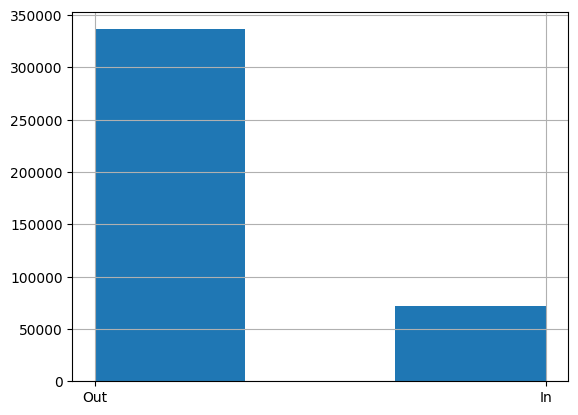

In [60]:
base_df['transaction_direction'].hist(bins=3)

In [61]:
base_df.groupby('transaction_direction').describe()

amount_n26_currency                                     \
                                    count        mean         std  min   25%   
transaction_direction                                                          
In                                72125.0  138.968721  195.956845  3.0  19.0   
Out                              336421.0   34.282845   70.930619  3.0   7.0   

                                            
                        50%    75%     max  
transaction_direction                       
In                     58.0  175.0  1166.0  
Out                    14.0   30.0  1166.0

<Axes: xlabel='transaction_direction'>

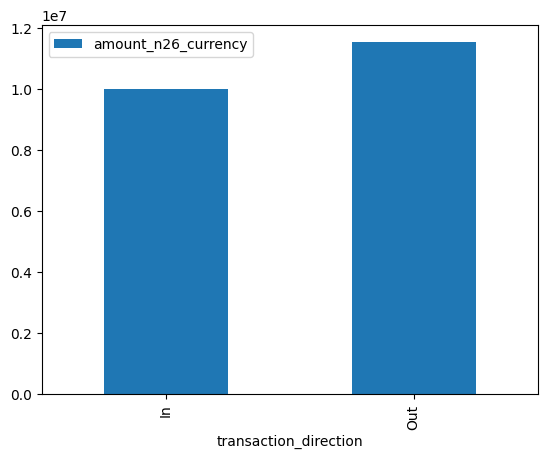

In [62]:
base_df.groupby('transaction_direction').sum(numeric_only=True).plot(kind='bar')

lets see for each user

In [63]:
base_df.groupby(['user_id','transaction_direction']).agg({'amount_n26_currency':'sum'}).describe()

,amount_n26_currency
count,18825.000000
mean,1145.104276
std,1691.489642
min,3.000000
25%,156.000000
50%,538.000000
75%,1455.000000
max,26195.000000


In [64]:
base_df.groupby(['user_id','transaction_direction']).agg({'amount_n26_currency':'mean'}).describe()

,amount_n26_currency
count,18825.000000
mean,93.460786
std,126.644937
min,3.000000
25%,20.312500
50%,42.158273
75%,112.833333
max,1165.000000


seasonality, trend & feature distributions

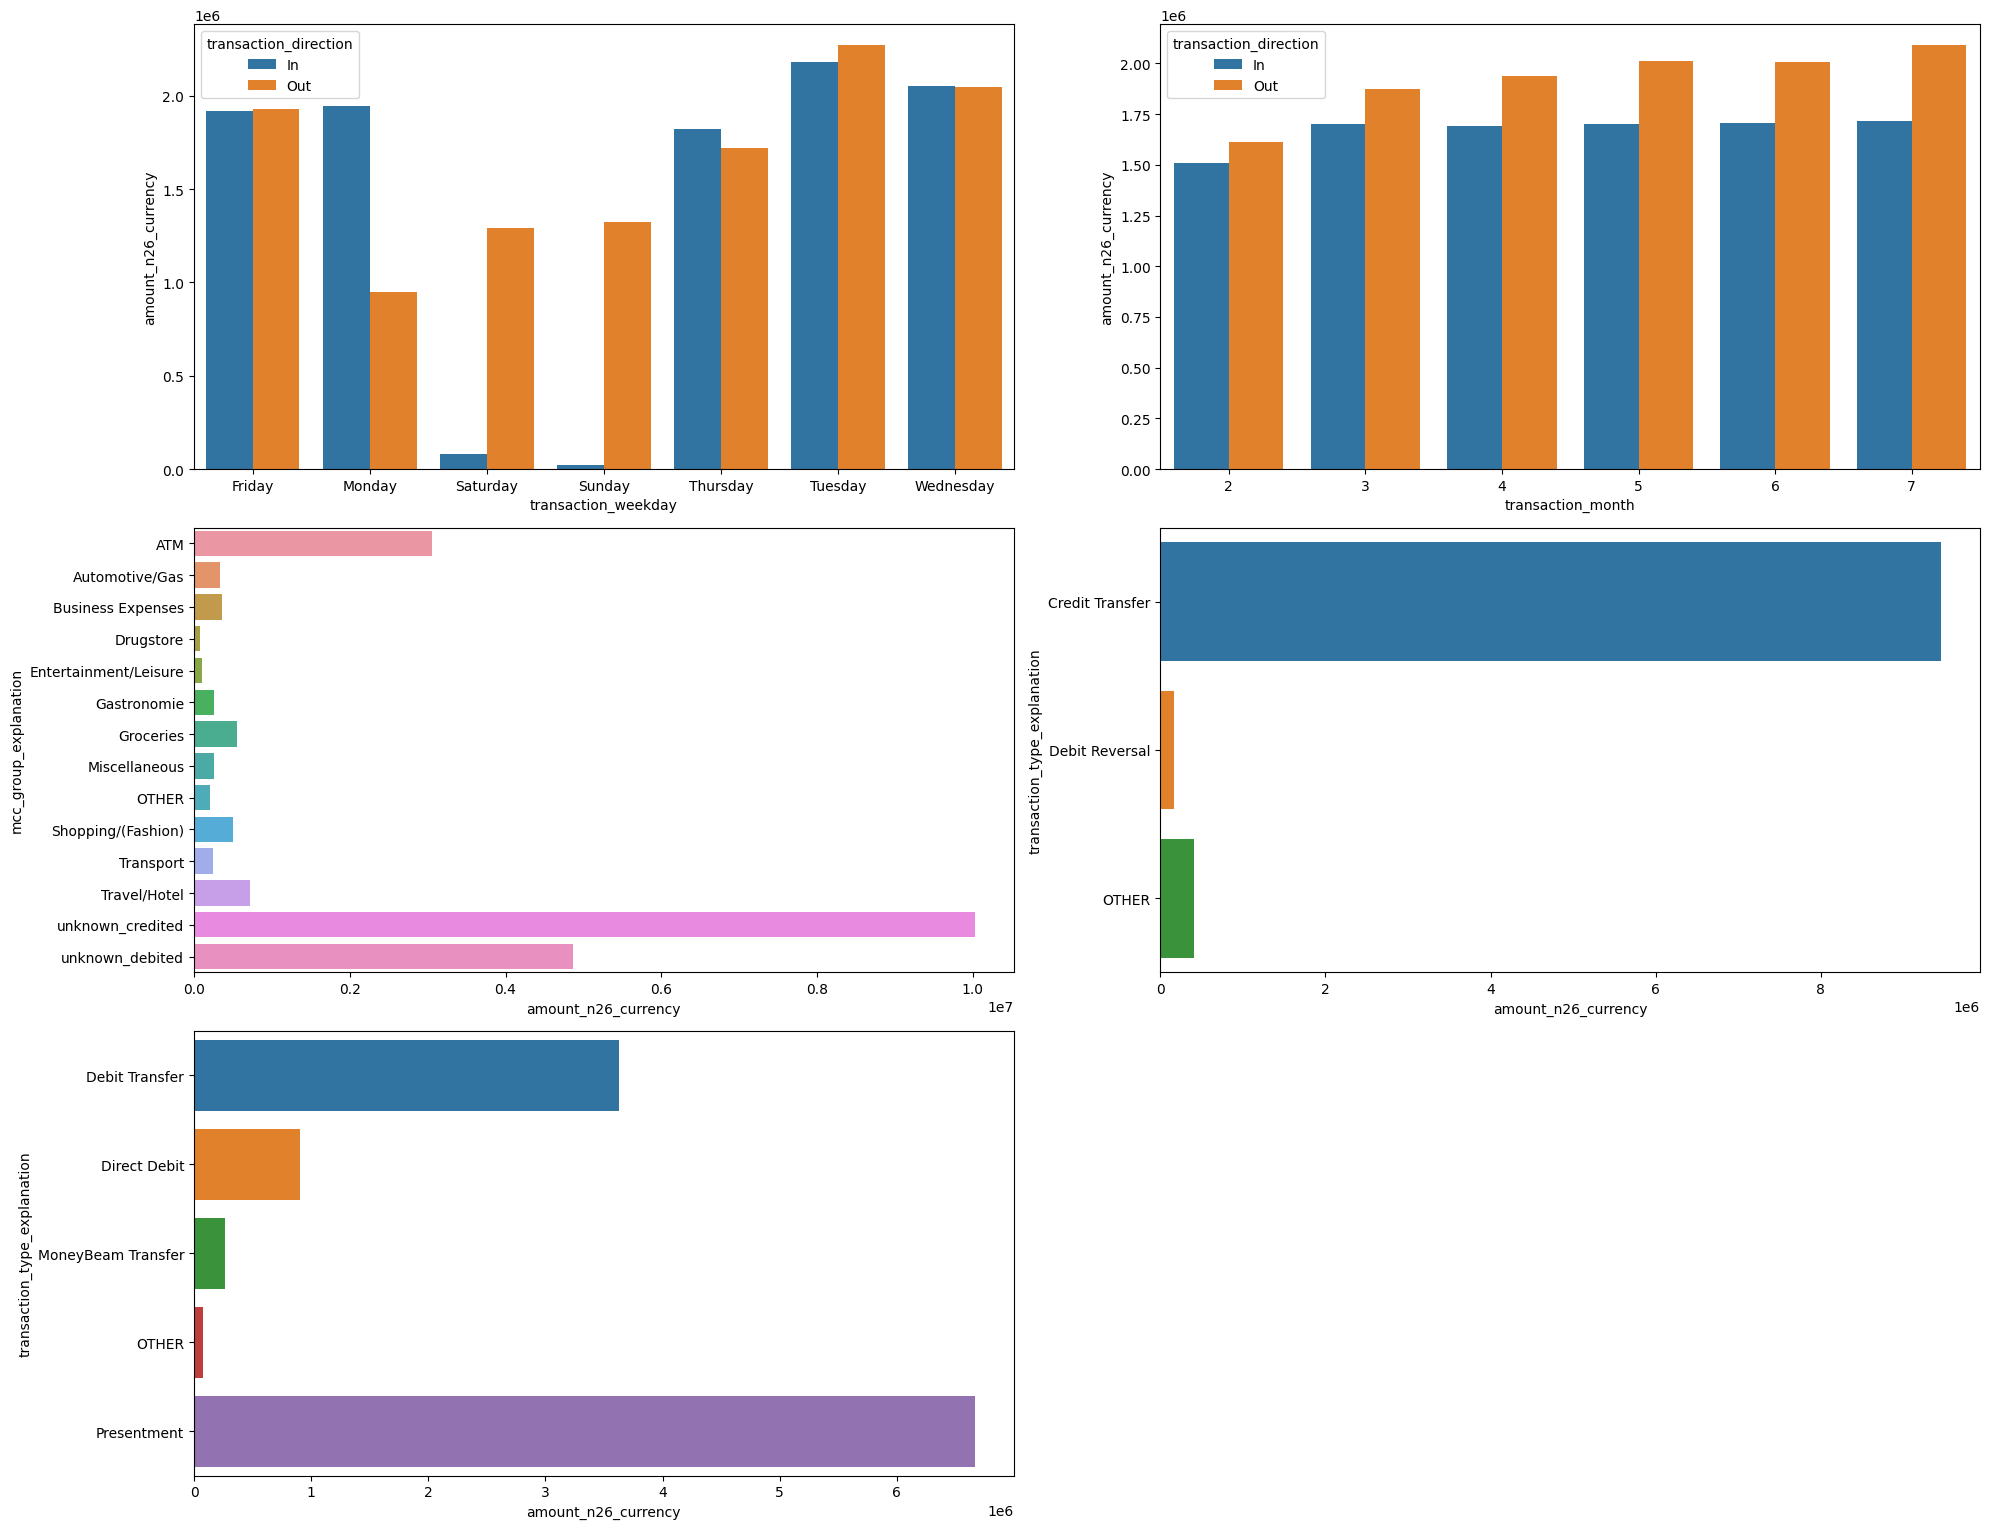

In [65]:
dummy = base_df.copy()
dummy['transaction_date'] = pd.to_datetime(dummy['transaction_date'])
dummy['transaction_weekday'] = dummy['transaction_date'].dt.weekday
dummy['transaction_weekday'] = dummy['transaction_weekday'].apply(lambda x: calendar.day_name[x])
dummy['transaction_month'] = dummy['transaction_date'].dt.month
dummy['transaction_year'] = dummy['transaction_date'].dt.year
dummy['transaction_day'] = dummy['transaction_date'].dt.day

plt.figure(figsize=(20, 20))

# First subplot
plt.subplot(4, 2, 1)
sns.barplot(x="transaction_weekday", y="amount_n26_currency", hue='transaction_direction',
            data=dummy.groupby(['transaction_direction', 'transaction_weekday']).agg({'amount_n26_currency': 'sum'}).reset_index())

# Second subplot
plt.subplot(4, 2, 2)
sns.barplot(x="transaction_month", y="amount_n26_currency", hue='transaction_direction',
            data=dummy.groupby(['transaction_direction', 'transaction_month']).agg({'amount_n26_currency': 'sum'}).reset_index())

# Third subplot
plt.subplot(4, 2, 3)
sns.barplot(x="amount_n26_currency", y="mcc_group_explanation",
            data=dummy.groupby('mcc_group_explanation').agg({'amount_n26_currency': 'sum'}).reset_index())

# Fifth subplot
plt.subplot(4, 2, 4)
sns.barplot(x="amount_n26_currency", y="transaction_type_explanation",
            data=dummy[dummy.transaction_direction == 'In'].groupby(['transaction_type_explanation']).agg({'amount_n26_currency': 'sum'}).reset_index())

# Seventh subplot
plt.subplot(4, 2, 5)
sns.barplot(x="amount_n26_currency", y="transaction_type_explanation",
            data=dummy[dummy.transaction_direction == 'Out'].groupby(['transaction_type_explanation']).agg({'amount_n26_currency': 'sum'}).reset_index())

plt.tight_layout()
plt.show()


# Feature Engineering

Let's first prepare the given data for feature creation step.

In [9]:
'''
fill missing values (mcc_group_explanation -> credited (in) and debited (out)	)
maybe add unknown_credited, unknown_debited
'''

condition_in = (base_df['transaction_direction'] == 'In') & (base_df['mcc_group_explanation'].isna())
condition_out = (base_df['transaction_direction'] == 'Out') & (base_df['mcc_group_explanation'].isna())

base_df.loc[condition_in, 'mcc_group_explanation'] = 'unknown_credited'
base_df.loc[condition_out, 'mcc_group_explanation'] = 'unknown_debited'

In [10]:
'''
group categories with less than 0.01 percent of total to 'OTHER'
'''

categorical_cols = ['transaction_type_explanation', 'transaction_direction', 'transaction_agent', 'mcc_group_explanation']
# Define the threshold for grouping values as 'OTHER'
threshold = 0.04

for col in categorical_cols:
    # Calculate the value counts as a proportion of the total
    value_counts = base_df[col].value_counts(normalize=True).reset_index()

    # Find unique values with a proportion less than the threshold
    rows = value_counts[value_counts[col] < threshold]['index'].unique()

    # Update values in both training and validation dataframes
    base_df[col] = np.where(base_df[col].isin(rows), 'OTHER', base_df[col])

# base_df.mcc_group_explanation.value_counts(dropna=False,normalize=True)

Let's now use base data to create feature set for each user.

In [11]:
'''
get base user list along with total in and out transactions along with sum and mean of amount
'''
base_feature_df = base_df.groupby(['user_id', 'transaction_direction']).agg(
    amount_sum=('amount_n26_currency', 'sum'),
    amount_mean=('amount_n26_currency', 'mean')
).reset_index()

# Pivot to separate columns for 'In' and 'Out'
pivot_df = base_feature_df.pivot(index='user_id', columns='transaction_direction', values=['amount_sum', 'amount_mean']).reset_index()
pivot_df.columns = [f"{col[0]}_{col[1]}" if col[1] else col[0] for col in pivot_df.columns]

base_feature_df = pivot_df.fillna(0)  # Fill NaN with zeros if needed
# base_feature_df.head()

In [12]:
'''
Add RFM features
'''
# Define a function to calculate RFM
def calculate_rfm(df, transaction_type, latest_date):
    filtered_df = df[df['transaction_direction'] == transaction_type]
    # Recency
    recency_df = filtered_df.groupby('user_id')['transaction_date'].max().reset_index()
    recency_df['Recency_{}'.format(transaction_type)] = (latest_date - recency_df['transaction_date']).dt.days
    # Frequency
    frequency_df = filtered_df.groupby('user_id')['transaction_date'].count().reset_index()
    frequency_df.columns = ['user_id', 'Frequency_{}'.format(transaction_type)]
    # Monetary
    monetary_df = filtered_df.groupby('user_id')['amount_n26_currency'].sum().reset_index()
    monetary_df.columns = ['user_id', 'Monetary_{}'.format(transaction_type)]
    # Merge
    temp_df = pd.merge(recency_df, frequency_df, on='user_id')
    rfm_df = pd.merge(temp_df, monetary_df, on='user_id')
    return rfm_df.drop('transaction_date', axis=1)

# Your existing latest_date calculation
latest_date = base_df['transaction_date'].max()
# Calculate RFM for 'In' transactions
rfm_in_df = calculate_rfm(base_df, 'In', latest_date)
# Calculate RFM for 'Out' transactions
rfm_out_df = calculate_rfm(base_df, 'Out', latest_date)

# Merge RFMs with base_feature_temp
base_feature_temp = base_feature_df.copy()
new_features = rfm_in_df.drop('user_id',axis=1).columns.tolist() + rfm_out_df.drop('user_id',axis=1).columns.tolist()

base_feature_temp.drop(columns=new_features,axis=1,errors='ignore',inplace=True)
base_feature_temp = pd.merge(base_feature_temp, rfm_in_df, on='user_id', how='left')
base_feature_temp = pd.merge(base_feature_temp, rfm_out_df, on='user_id', how='left')

# fill missing values
base_feature_temp[['Recency_In', 'Recency_Out']] = base_feature_temp[['Recency_In', 'Recency_Out']].fillna(base_df['transaction_date'].max())
base_feature_temp[['Frequency_In', 'Frequency_Out']] = base_feature_temp[['Frequency_In', 'Frequency_Out']].fillna(0)
base_feature_temp[['Monetary_In', 'Monetary_Out']] = base_feature_temp[['Monetary_In', 'Monetary_Out']].fillna(0)

base_feature_df.drop(columns=new_features,axis=1,errors='ignore',inplace=True)
base_feature_df[new_features] = base_feature_temp[['Recency_In',	'Frequency_In',	'Monetary_In', 'Recency_Out',	'Frequency_Out',	'Monetary_Out']]
# base_feature_df

In [13]:
'''
New_features:
'latest_date_expenditure', 'latest_date_income',
       'earliest_date_expenditure', 'earliest_date_income',
       'user_expenditure_platform_age', 'user_income_platform_age'
'''
def calculate_platform_age(base_df):
    grouped = base_df.groupby(['user_id', 'transaction_direction'])['transaction_date'].agg(['max', 'min']).reset_index()
    user_platform_age = grouped.pivot(index='user_id', columns='transaction_direction', values=['max', 'min']).reset_index()
    user_platform_age.columns = ['user_id', 'latest_date_expenditure', 'latest_date_income', 'earliest_date_expenditure', 'earliest_date_income']

    user_platform_age['user_expenditure_platform_age'] = (user_platform_age['latest_date_expenditure'] - user_platform_age['earliest_date_expenditure']).dt.days
    user_platform_age['user_expenditure_platform_age'].fillna(round(user_platform_age['user_expenditure_platform_age'].mean()), inplace=True)
    user_platform_age['user_income_platform_age'] = (user_platform_age['latest_date_income'] - user_platform_age['earliest_date_income']).dt.days
    user_platform_age['user_income_platform_age'].fillna(round(user_platform_age['user_income_platform_age'].mean()), inplace=True)

    return user_platform_age

# calculating new features
result = calculate_platform_age(base_df.copy())

# merging new feaetures
new_feature_names = result.drop('user_id',axis=1).columns
base_feature_df.drop(columns=new_feature_names,axis=1,errors='ignore',inplace=True) # make sure they dont exist in df already
base_feature_df = pd.merge(base_feature_df,result,on='user_id',how='left')
# base_feature_df

In [14]:
'''
All aggregated features that can be derived from within the DF
'''
# Total income
base_feature_df['total_balance'] = base_feature_df['amount_sum_In'] - base_feature_df['amount_sum_Out']
base_feature_df['total_transactions'] = base_feature_df['Frequency_In'] + base_feature_df['Frequency_Out']
base_feature_df['total_spend_ratio'] = base_feature_df['Frequency_Out'] / base_feature_df['total_transactions']
base_feature_df['total_income_ratio'] = base_feature_df['Frequency_In'] / base_feature_df['total_transactions']
base_feature_df['income_to_spend_ratio'] = base_feature_df['Frequency_In'] / base_feature_df['Frequency_Out']
base_feature_df['avg_daily_income'] = base_feature_df['amount_sum_In'] / base_feature_df['user_income_platform_age']
base_feature_df['avg_daily_expense'] = base_feature_df['amount_sum_Out'] / base_feature_df['user_expenditure_platform_age']
base_feature_df.avg_daily_income.fillna(0,inplace=True)
base_feature_df.avg_daily_expense.fillna(0,inplace=True)
# base_feature_df

In [15]:
'''
monthly growth rate
'''
# Convert 'transaction_date' to datetime and extract month
base_df['transaction_date'] = pd.to_datetime(base_df['transaction_date'])
base_df['transaction_month'] = base_df['transaction_date'].dt.to_period('M')

# Sum the amount for each user for each month
monthly_sum = base_df.groupby(['user_id', 'transaction_month'])['amount_n26_currency'].sum().reset_index()

# Sort data for calculations
monthly_sum.sort_values(['user_id', 'transaction_month'], inplace=True)

# Calculate the monthly growth rate
monthly_sum['previous_amount'] = monthly_sum.groupby('user_id')['amount_n26_currency'].shift(1)
monthly_sum['growth_rate'] = ((monthly_sum['amount_n26_currency'] - monthly_sum['previous_amount']) / monthly_sum['previous_amount']) * 100

# Drop NaN and inf values, which will be present for the first month for each user
monthly_sum.dropna(inplace=True)
monthly_sum.replace([float('inf'), -float('inf')], 0, inplace=True)

# Final DataFrame will have columns 'user_id', 'transaction_month', 'amount_n26_currency', 'previous_amount', 'growth_rate'
pivot_df = monthly_sum.pivot(index='user_id',columns='transaction_month',values='growth_rate').reset_index()
# Rename columns by extracting month number
new_columns = [(col.month if hasattr(col, 'month') else col) for col in pivot_df.columns]
pivot_df.columns = new_columns

# Perform the pivot operation
pivot_df = monthly_sum.pivot(index='user_id', columns='transaction_month', values='growth_rate').reset_index()

# Rename columns by extracting month number and adding prefix "month_"
new_columns = [(f"month_{col.month}" if hasattr(col, 'month') else col) for col in pivot_df.columns]
pivot_df.columns = new_columns

# pivot_df.info()

#merge into feature set
new_feature_names = pivot_df.drop('user_id',axis=1).columns
base_feature_df.drop(columns=new_feature_names,axis=1,errors='ignore',inplace=True) # make sure they dont exist in df already
base_feature_df = pd.merge(base_feature_df,pivot_df,on='user_id',how='left')
base_feature_df[new_columns] = base_feature_df[new_columns].fillna(0)

# base_feature_df

In [16]:
'''
tranaction amounts by each transaction type, mcc group and agent
'''

# calculate sum of amount for each transaction type
temp_df = base_df.groupby(['user_id','transaction_type_explanation']).agg(transaction_amount_with_type=('amount_n26_currency','sum')).reset_index()
pivot_df = temp_df.pivot(index = 'user_id', columns='transaction_type_explanation', values='transaction_amount_with_type').reset_index()
pivot_df = pivot_df.fillna(0)

#merge into feature set
new_feature_names = pivot_df.drop('user_id',axis=1).columns
base_feature_df.drop(columns=new_feature_names,axis=1,errors='ignore',inplace=True) # make sure they dont exist in df already
base_feature_df = pd.merge(base_feature_df,pivot_df,on='user_id',how='left')

# calculate sum of amount for each mcc group type
temp_df = base_df.groupby(['user_id','mcc_group_explanation']).agg(transaction_amount_for_mcc_group=('amount_n26_currency','sum')).reset_index()
pivot_df = temp_df.pivot(index = 'user_id', columns='mcc_group_explanation', values='transaction_amount_for_mcc_group').reset_index()
pivot_df = pivot_df.fillna(0)

#merge into feature set
new_feature_names = pivot_df.drop('user_id',axis=1).columns
base_feature_df.drop(columns=new_feature_names,axis=1,errors='ignore',inplace=True) # make sure they dont exist in df already
base_feature_df = pd.merge(base_feature_df,pivot_df,on='user_id',how='left')

# base_feature_df

In [17]:
# let's drop date columns, we don't want the dates to have effect on results.
base_feature_df.drop(columns=['latest_date_expenditure','latest_date_income','earliest_date_expenditure','earliest_date_income'],errors='ignore',inplace=True)

In [18]:
# from sklearn.preprocessing import OneHotEncoder
# # conversting categorical to one-hot-encodings and summing them up.
# categorical_cols = ['transaction_type_explanation', 'transaction_agent', 'mcc_group_explanation']
# categorical_data = base_df[categorical_cols]

# ohe = OneHotEncoder(categories='auto', handle_unknown='ignore')

# feature_arr = ohe.fit_transform(categorical_data).toarray()
# ohe_labels = ohe.get_feature_names_out(categorical_cols)
# ohe_features = pd.DataFrame(feature_arr, columns=ohe_labels)

# ohe_features = base_df[['user_id']].join(ohe_features)
# ohe_features = ohe_features.groupby('user_id').sum().reset_index()
# base_feature_df = base_feature_df.merge(ohe_features, how='left')
# base_feature_df.fillna(0, inplace=True)

In [19]:
base_feature_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 38 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   user_id                        10000 non-null  object 
 1   amount_sum_In                  10000 non-null  float64
 2   amount_sum_Out                 10000 non-null  float64
 3   amount_mean_In                 10000 non-null  float64
 4   amount_mean_Out                10000 non-null  float64
 5   Recency_In                     10000 non-null  object 
 6   Frequency_In                   10000 non-null  float64
 7   Monetary_In                    10000 non-null  float64
 8   Recency_Out                    10000 non-null  object 
 9   Frequency_Out                  10000 non-null  float64
 10  Monetary_Out                   10000 non-null  float64
 11  user_expenditure_platform_age  10000 non-null  float64
 12  user_income_platform_age       10000 non-null  

In [20]:
base_feature_df

,user_id,amount_sum_In,amount_sum_Out,amount_mean_In,amount_mean_Out,Recency_In,Frequency_In,Monetary_In,Recency_Out,Frequency_Out,...,Presentment,ATM,Automotive/Gas,Gastronomie,Groceries,OTHER,Shopping/(Fashion),Travel/Hotel,unknown_credited,unknown_debited
0,000295594379774ab9ac2c78c946d615,942.0,902.0,235.500000,64.428571,58.0,4.0,942.0,25.0,14.0,...,884.0,859.0,0.0,0.0,0.0,12.0,9.0,4.0,942.0,18.0
1,000aa792d73dd82b16a29692772d395a,815.0,706.0,271.666667,32.090909,27.0,3.0,815.0,9.0,22.0,...,162.0,0.0,0.0,0.0,16.0,110.0,36.0,0.0,815.0,544.0
2,0011103fe4ba1264342882b7ab98c641,2083.0,1392.0,347.166667,53.538462,11.0,6.0,2083.0,0.0,26.0,...,1313.0,516.0,0.0,4.0,0.0,220.0,0.0,573.0,2083.0,79.0
3,001679c77c33d7efabf800596fb2a978,5392.0,5687.0,674.000000,78.986111,25.0,8.0,5392.0,1.0,72.0,...,3313.0,3186.0,85.0,0.0,0.0,13.0,29.0,0.0,5392.0,2374.0
4,001e72a2f4c4376f10011735dde39cd5,426.0,600.0,142.000000,31.578947,130.0,3.0,426.0,82.0,19.0,...,600.0,172.0,210.0,16.0,0.0,88.0,37.0,77.0,426.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,fff571276eaa49853039f6bfe1102fba,93.0,54.0,23.250000,13.500000,27.0,4.0,93.0,17.0,4.0,...,28.0,22.0,0.0,0.0,6.0,0.0,0.0,0.0,93.0,26.0
9996,fff6ea4b3659a969c62c17c1d1655394,0.0,336.0,0.000000,48.000000,2016-07-31 00:00:00,0.0,0.0,24.0,7.0,...,336.0,290.0,16.0,0.0,8.0,0.0,0.0,22.0,0.0,0.0
9997,fff9eec15875baad3df433c8780aa3bd,908.0,924.0,151.333333,36.960000,54.0,6.0,908.0,2.0,25.0,...,720.0,92.0,0.0,0.0,0.0,510.0,26.0,92.0,908.0,204.0
9998,fffd503ed2ecb63067b7369f4d668aed,1342.0,816.0,167.750000,20.400000,4.0,8.0,1342.0,8.0,40.0,...,641.0,275.0,40.0,0.0,94.0,125.0,46.0,61.0,1342.0,175.0


### **Visaulize created features**

In [21]:
base_df.transaction_date

0        2016-02-01
1        2016-02-01
2        2016-02-01
3        2016-02-01
4        2016-02-01
            ...    
408541   2016-07-31
408542   2016-07-31
408543   2016-07-31
408544   2016-07-31
408545   2016-07-31
Name: transaction_date, Length: 408546, dtype: datetime64[ns]

In [24]:
base_feature_df.drop(columns=['amount_sum_In','amount_sum_Out','unknown_debited','unknown_credited','Credit Transfer',
 'total_transactions'],inplace=True,errors='ignore')

In [ ]:
y_train = training_df[['user_id', 'direction', 'amount_n26_currency']].groupby(['user_id', 'direction']).agg({'amount_n26_currency': 'sum'}).reset_index()

<ipython-input-25-2fbb58e0b7e2>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = base_feature_df.corr()


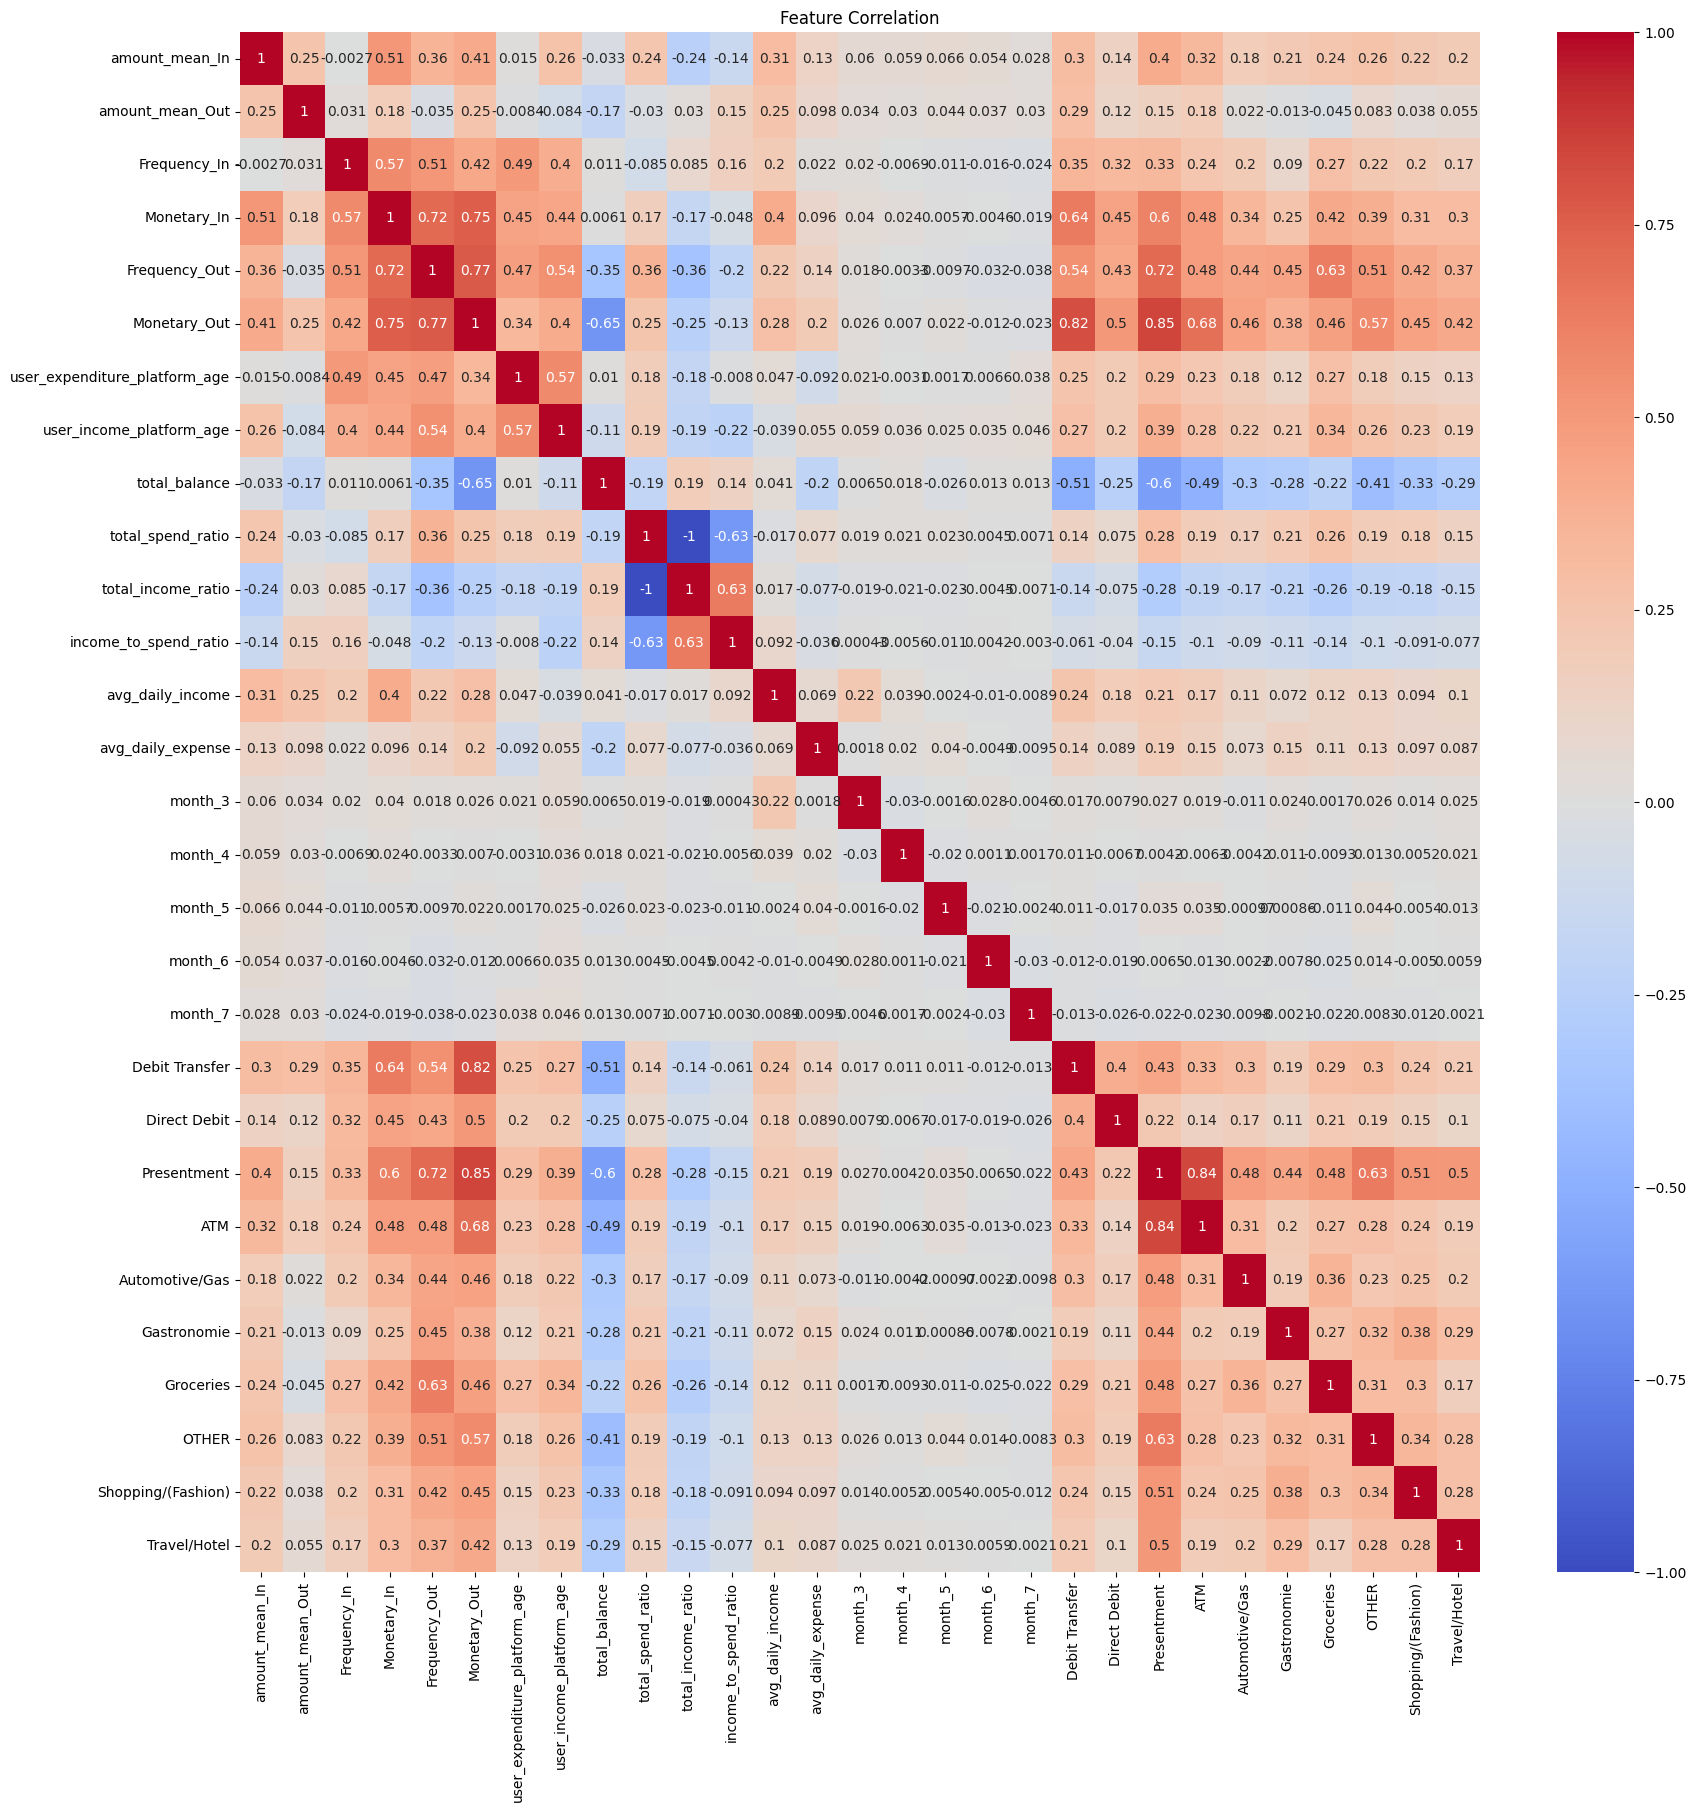

In [25]:
# Calculate the correlation matrix
corr_matrix = base_feature_df.corr()

# Generate a heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Feature Correlation')
plt.show()

In [26]:
base_df.transaction_date.min(), base_df.transaction_date.max()

(Timestamp('2016-02-01 00:00:00'), Timestamp('2016-07-31 00:00:00'))

In [ ]:
y_train = training_df[['user_id', 'direction', 'amount_n26_currency']].groupby(['user_id', 'direction']).agg({'amount_n26_currency': 'sum'}).reset_index()


# **Preprocessing**

In [85]:
# replace inf values with 0
base_feature_df.replace([np.inf, -np.inf], 0, inplace=True)

In [86]:
base_feature_df

,user_id,amount_mean_In,amount_mean_Out,Recency_In,Frequency_In,Monetary_In,Recency_Out,Frequency_Out,Monetary_Out,user_expenditure_platform_age,...,Debit Transfer,Direct Debit,Presentment,ATM,Automotive/Gas,Gastronomie,Groceries,OTHER,Shopping/(Fashion),Travel/Hotel
0,000295594379774ab9ac2c78c946d615,235.500000,64.428571,58.0,4.0,942.0,25.0,14.0,902.0,105.0,...,18.0,0.0,884.0,859.0,0.0,0.0,0.0,12.0,9.0,4.0
1,000aa792d73dd82b16a29692772d395a,271.666667,32.090909,27.0,3.0,815.0,9.0,22.0,706.0,56.0,...,511.0,33.0,162.0,0.0,0.0,0.0,16.0,110.0,36.0,0.0
2,0011103fe4ba1264342882b7ab98c641,347.166667,53.538462,11.0,6.0,2083.0,0.0,26.0,1392.0,146.0,...,0.0,0.0,1313.0,516.0,0.0,4.0,0.0,220.0,0.0,573.0
3,001679c77c33d7efabf800596fb2a978,674.000000,78.986111,25.0,8.0,5392.0,1.0,72.0,5687.0,155.0,...,2374.0,0.0,3313.0,3186.0,85.0,0.0,0.0,13.0,29.0,0.0
4,001e72a2f4c4376f10011735dde39cd5,142.000000,31.578947,130.0,3.0,426.0,82.0,19.0,600.0,34.0,...,0.0,0.0,600.0,172.0,210.0,16.0,0.0,88.0,37.0,77.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,fff571276eaa49853039f6bfe1102fba,23.250000,13.500000,27.0,4.0,93.0,17.0,4.0,54.0,112.0,...,26.0,0.0,28.0,22.0,0.0,0.0,6.0,0.0,0.0,0.0
9996,fff6ea4b3659a969c62c17c1d1655394,0.000000,48.000000,2016-07-31 00:00:00,0.0,0.0,24.0,7.0,336.0,101.0,...,0.0,0.0,336.0,290.0,16.0,0.0,8.0,0.0,0.0,22.0
9997,fff9eec15875baad3df433c8780aa3bd,151.333333,36.960000,54.0,6.0,908.0,2.0,25.0,924.0,106.0,...,0.0,10.0,720.0,92.0,0.0,0.0,0.0,510.0,26.0,92.0
9998,fffd503ed2ecb63067b7369f4d668aed,167.750000,20.400000,4.0,8.0,1342.0,8.0,40.0,816.0,153.0,...,175.0,0.0,641.0,275.0,40.0,0.0,94.0,125.0,46.0,61.0


In [45]:
'''
Add more features as source code
'''


# from joblib import dump, load

# def m_get_features(training_df, train, skip_categorical=False):





#     # we will test the code with and without categorical variables.
#     if skip_categorical:
#         return user_txn_features


#     # conversting categorical to one-hot-encodings and summing them up.
#     categorical_cols = ['transaction_type_explanation', 'agent', 'mcc_group_explanation']
#     categorical_data = training_df[categorical_cols]

#     if train:
#         ohe = OneHotEncoder(categories='auto', handle_unknown='ignore')
#         feature_arr = ohe.fit_transform(categorical_data).toarray()
#         dump(ohe, f'OHE.pkl')
#     else:
#         ohe = load(f'OHE.pkl')
#         feature_arr = ohe.transform(categorical_data).toarray()

#     feature_arr = ohe.fit_transform(categorical_data).toarray()
#     ohe_labels = ohe.get_feature_names_out(categorical_cols)
#     ohe_features = pd.DataFrame(feature_arr, columns=ohe_labels)

#     ohe_features = training_df[['user_id']].join(ohe_features)
#     ohe_features = ohe_features.groupby('user_id').sum().reset_index()
#     user_txn_features = user_txn_features.merge(ohe_features, how='left')
#     user_txn_features.fillna(0, inplace=True)

#     return user_txn_features


'\nAdd more features as source code\n'